### Импорты: назначение библиотек

- **`struct`**: для работы с двоичными файлами (чтение и интерпретация данных).
- **`numpy`**: для обработки данных и выполнения математических операций.
- **`intvalpy`**: для работы с интервалами и интервальными вычислениями.
- **`matplotlib.pyplot`** и **`seaborn`**: для визуализации данных (графики, гистограммы).
- **`scipy.stats.zscore`**: для нормализации данных с использованием z-оценок.
- **`functools.cmp_to_key`**: для кастомной сортировки.
- **`pathlib.Path`**: для упрощённой работы с путями к файлам.


In [1]:
import struct
import numpy as np
import intvalpy as ip
import matplotlib.pyplot as plt
import seaborn as sns
from functools import cmp_to_key
from scipy.stats import zscore
from pathlib import Path

### Чтение данных из бинарных файлов: `read_bin_file_with_numpy`

Эта функция считывает двоичный файл с данными и возвращает массив кадров.

**Шаги работы функции:**
1. Заголовок файла (256 байт) содержит параметры:
   - `side`: сторона измерения;
   - `mode`: режим работы;
   - `frame_count`: количество кадров.
2. Для каждого кадра:
   - Чтение заголовка кадра (16 байт), где хранятся:
     - `stop_point`: позиция остановки;
     - `timestamp`: временная метка.
   - Чтение данных точки (16 * 1024 байт на кадр).
3. Итог: массив всех кадров в формате NumPy.

**Назначение:** получение структурированных данных из двоичного файла для последующего анализа.


In [2]:
def read_bin_file_with_numpy(file_path):
  with open(file_path, 'rb') as f:
    header_data = f.read(256)
    side, mode, frame_count = struct.unpack('<BBH', header_data[:4])

    frames = []
    point_dtype = np.dtype('<8H')

    for _ in range(frame_count):
      frame_header_data = f.read(16)
      stop_point, timestamp = struct.unpack('<HL', frame_header_data[:6])
      frame_data = np.frombuffer(f.read(1024 * 16), dtype=point_dtype)
      frames.append(frame_data)

    return np.array(frames)

### Преобразование в напряжение: `convert_to_voltage`

**Формула преобразования:**
$
\text{voltage} = \frac{\text{data}}{16384} - 0.5
$

**Зачем это нужно:** нормализовать данные в диапазоне, удобном для анализа.


In [3]:
def convert_to_voltage(data):
  return data / 16384.0 - 0.5

### Работа с интервалами: основные функции

1. **`are_intersected(x, y)`**  
   Проверяет, пересекаются ли два интервала `x` и `y`.  
   Возвращает `True`, если разница между верхним и нижним концом ≤ $10^{-15}$.

2. **`are_adjusted_to_each_other(x, y)`**  
   Проверяет, являются ли интервалы смежными (границы одного совпадают с границами другого).

3. **`merge_intervals(x, y)`**  
   Объединяет два интервала в новый, который покрывает минимальные и максимальные границы обоих интервалов.


In [4]:
def are_intersected(x, y):
  sup = y.a if x.a < y.a else x.a
  inf = x.b if x.b < y.b else y.b
  return sup - inf <= 1e-15

In [5]:
def are_adjusted_to_each_other(x, y):
  return x.b == y.a or y.b == x.a

In [6]:
def merge_intervals(x, y):
  return ip.Interval(min(x.a, y.a), max(x.b, y.b))

### Вычисление моды: `mode`

Находит **моду** (наиболее частые интервалы) в списке интервалов.

**Шаги работы функции:**
1. Создание множества всех границ интервалов.
2. Формирование новых интервалов между соседними границами.
3. Подсчёт количества исходных интервалов, которые покрывают каждый новый интервал.
4. Выбор интервалов с максимальной частотой.

**Результат:** список мод, объединённых по необходимости.

**Зачем это нужно:** для нахождения наиболее "плотных" зон данных.


In [7]:
def mode(x):
  if len(x) == 0:
    return []

  edges = sorted({x_i.a for x_i in x}.union({x_i.b for x_i in x}))
  z = [ip.Interval(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]
  mu = [sum(1 for x_i in x if z_i in x_i) for z_i in z]

  max_mu = max(mu)
  K = [index for index, element in enumerate(mu) if element == max_mu]

  m = [z[k] for k in K]
  merged_m = []

  current_interval = m[0]

  for next_interval in m[1:]:
    if are_intersected(current_interval, next_interval) or are_adjusted_to_each_other(current_interval, next_interval):
      current_interval = merge_intervals(current_interval, next_interval)
    else:
      merged_m.append(current_interval)
      current_interval = next_interval

  merged_m.append(current_interval)

  return merged_m

### Вычисление медиан: `med_k` и `med_p`

1. **`med_k(x)`**  
   Вычисляет медиану как интервал между медианами начальных и конечных точек всех интервалов.

2. **`med_p(x)`**  
   Определяет медиану на основе центральных значений интервалов, сортируя их по средним точкам.

**Зачем это нужно:** для представления центрального значения данных в интервальном виде.


In [8]:
def med_k(x):
  starts = [float(interval.a) for interval in x]
  ends = [float(interval.b) for interval in x]
  return ip.Interval(np.median(starts), np.median(ends))

In [9]:
def med_p(x):
  x = sorted(x, key=cmp_to_key(lambda x, y: (x.a + x.b) / 2 - (y.a + y.b) / 2))

  mid_index = len(x) // 2

  if len(x) % 2 == 0:
    return (x[mid_index - 1] + x[mid_index]) / 2

  return x[mid_index]

### Индекс Жаккара: `jaccard_index`

**Назначение:** измеряет схожесть двух интервалов (или списков интервалов).

**Формула для двух интервалов:**
$
J(A, B) = \frac{|A \cap B|}{|A \cup B|}
$

**Обобщение:** поддерживает работу как с одиночными интервалами, так и с их списками.

**Применение:** используется для оценки пересечения и различий между интервалами.


In [10]:
def jaccard_index(*args):
  if len(args) == 1:
    x = args[0]
    left_edges = [interval.a for interval in x]
    right_edges = [interval.b for interval in x]

    return (min(right_edges) - max(left_edges)) / (max(right_edges) - min(left_edges))
  elif len(args) == 2:
    x = args[0]
    y = args[1]

    if isinstance(x, ip.ClassicalArithmetic) and isinstance(y, ip.ClassicalArithmetic):
      return (min(x.b, y.b) - max(x.a, y.a)) / (max(x.b, y.b) - min(x.a, y.a))
    else:
      results = []

      for x_i, y_i in zip(x, y):
        result = (min(x_i.b, y_i.b) - max(x_i.a, y_i.a)) / (max(x_i.b, y_i.b) - min(x_i.a, y_i.a))
        results.append(result)

      return np.array(results)
  else:
    raise ValueError("Wrong number of arguments")

### Интервальное представление: `scalar_to_interval`

**Назначение:** преобразует число в интервал с заданным радиусом.  
Это необходимо для моделирования неопределённости данных.

**Пример использования:**  
Радиус интервала задаётся как $ 2^{-14} $, что соответствует точности преобразования.


In [11]:
def scalar_to_interval(x, rad):
  return ip.Interval(x - rad, x + rad)
scalar_to_interval_vec = np.vectorize(scalar_to_interval)

### Визуализация данных

- Данные считываются из файлов `-0.205_lvl_side_a_fast_data.bin` и `0.225_lvl_side_a_fast_data.bin`.
- Построение гистограмм: **`sns.histplot`**.
- Построение точечных графиков: **`plt.scatter`**.
- Данные нормализуются с помощью z-оценок и фильтруются для исключения выбросов.

**Зачем это нужно:** для первичного анализа распределения данных.


### Чтение бинарных файлов

Этот фрагмент кода загружает данные из двух бинарных файлов `-0.205_lvl_side_a_fast_data.bin` и `0.225_lvl_side_a_fast_data.bin` с помощью функции `read_bin_file_with_numpy`. 

- **Цель**: загрузить данные измерений из двух источников для последующего анализа.
- **Результат**: переменные `x_data` и `y_data` содержат массивы данных, представляющие измерения.

In [12]:
x_data = read_bin_file_with_numpy('-0.205_lvl_side_a_fast_data.bin')
y_data = read_bin_file_with_numpy('0.225_lvl_side_a_fast_data.bin')

### Задание списка файлов

В этом блоке создаётся список файлов, которые будут использоваться в дальнейших вычислениях.

- **Path**: используется для представления пути к файлам, что упрощает работу с файловой системой.
- **Назначение**: определить набор данных для анализа.

In [13]:
files = [Path('-0.205_lvl_side_a_fast_data.bin'), Path('0.225_lvl_side_a_fast_data.bin')]

### Построение распределения данных

Этот код строит гистограммы распределений данных для каждого файла из списка `files`.

- **`plt.subplots(1, 2, figsize=(15, 5))`**: создаётся холст с двумя подграфиками.
- **Чтение данных**: функция `read_bin_file_with_numpy` извлекает данные, которые затем преобразуются в одномерный массив.
- **`sns.histplot`**: строится гистограмма с включённой плотностной оценкой (параметр `kde=True`).
- **Результат**: на выходе две гистограммы, каждая из которых показывает распределение данных для соответствующего файла.


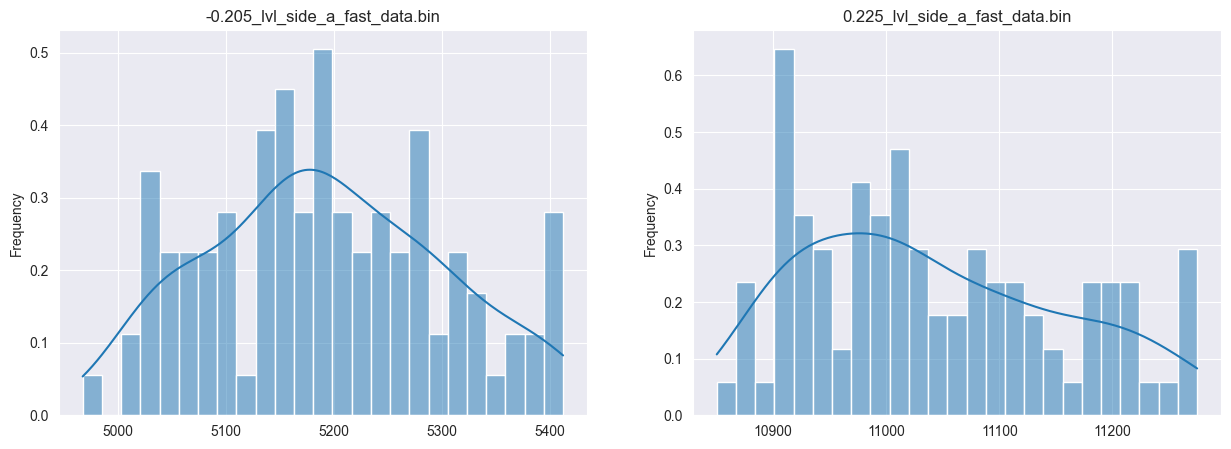

In [14]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

for index, file_path in enumerate(files):
  frames = read_bin_file_with_numpy(file_path)
  ys = []

  for frame in frames:
    px = frame.flatten()[0]
    ys.append(px)

  axis = axes[index]
  sns.histplot(ys, ax=axis, bins=25, stat='frequency', kde=True)
  axis.set_title(file_path)

### Преобразование данных в напряжение

Данный код преобразует исходные данные в единицы напряжения.

1. **`convert_to_voltage`**: применяется для перевода данных в диапазон напряжений.
   - Преобразование осуществляется по формуле: 
     $ \text{Voltage} = \frac{\text{data}}{16384.0} - 0.5 $

2. **`np.transpose`**: перестановка осей массива для упрощения дальнейшего анализа.
   - Исходный массив трансформируется так, чтобы порядок осей стал `(2, 1, 0)`.

In [15]:
x_voltage = convert_to_voltage(x_data)
y_voltage = convert_to_voltage(y_data)

x_voltage = np.transpose(x_voltage, axes=(2, 1, 0))
y_voltage = np.transpose(y_voltage, axes=(2, 1,0))

### Визуализация распределений

Строятся гистограммы распределений напряжений для первых наборов данных.

- **Цель**: визуально оценить распределение напряжений для одной из осей массива.
- **`bins=10`**: задаёт количество интервалов гистограммы.
- **Результат**: две гистограммы, показывающие распределение значений напряжений.

<Axes: ylabel='Count'>

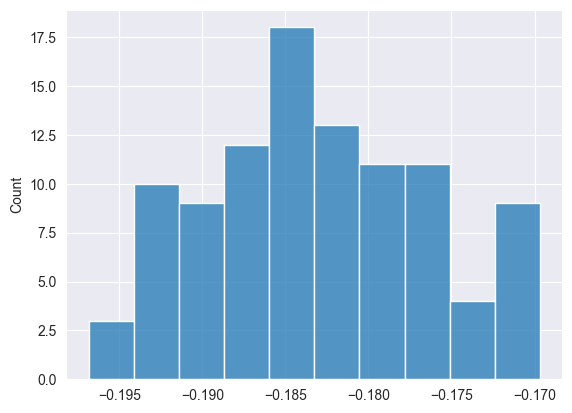

In [16]:
sns.histplot(x_voltage[0,0,:], bins=10)

<Axes: ylabel='Count'>

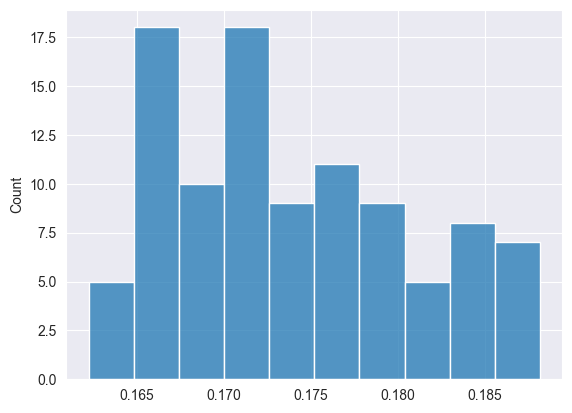

In [17]:
sns.histplot(y_voltage[0,0,:], bins=10)

### Упрощение данных (усреднение)

Этот блок усредняет данные по третьей оси.

- **Зачем?**: уменьшить размерность данных и устранить флуктуации по третьему измерению, чтобы упростить анализ.
- **Результат**: массивы `x_voltage` и `y_voltage` становятся двумерными.

In [18]:
x_voltage = np.mean(x_voltage, axis=2)
y_voltage = np.mean(y_voltage, axis=2)

### Построение графиков

Эти участки строят точечные графики напряжений.

- **`x_voltage.flatten()`**: сглаживает массив в одномерный.
- **`range`**: создаёт ось x, представляющую индексы точек.
- **Результат**: два графика, показывающих поведение напряжений.

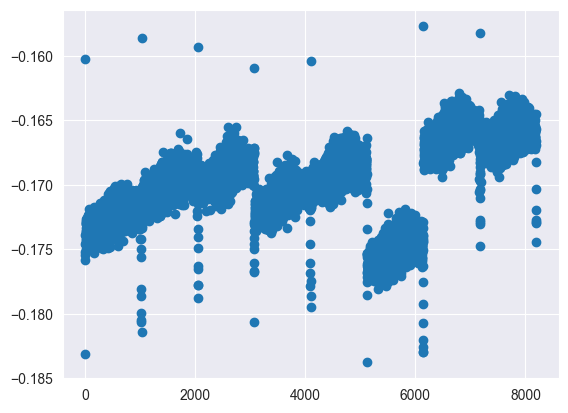

In [19]:
plt.scatter(list(range(1, x_voltage.flatten().shape[0]  + 1)), x_voltage.flatten())

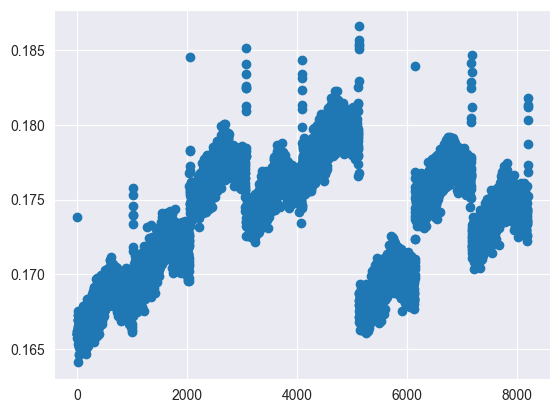

In [20]:
plt.scatter(list(range(1, y_voltage.flatten().shape[0]  + 1)), y_voltage.flatten())

### Сравнение двух сигналов

Здесь выбирается третий ряд данных (индекс 2) и строится график взаимного распределения двух сигналов.

- **`flatten`**: сглаживает ряды в одномерный массив.
- **`plt.scatter`**: строит диаграмму рассеяния, отображая зависимость между `x_voltage` и `y_voltage`.
- **Результат**: график зависимости напряжений между двумя наборами данных.

In [21]:
x_voltage = x_voltage[2].flatten()
y_voltage = y_voltage[2].flatten()

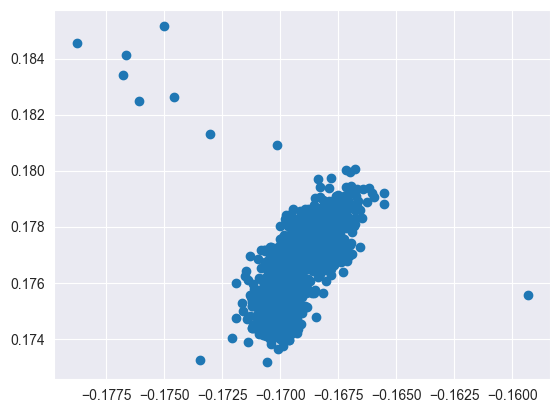

In [22]:
plt.scatter(x_voltage, y_voltage)

### Удаление выбросов

Этот код удаляет выбросы из данных на основе Z-оценок.

1. **Z-оценка**: показывает, насколько значение отклоняется от среднего в единицах стандартного отклонения.
2. **`threshold = 3`**: значения с отклонением более 3 стандартных отклонений считаются выбросами.
3. **Фильтрация**: выбросы исключаются из массивов.
- **Результат**: очищенные массивы `x_voltage` и `y_voltage`.

In [23]:
z_scores_x = zscore(x_voltage)
z_scores_y = zscore(y_voltage)

threshold = 3

non_outlier_indices = np.where((np.abs(z_scores_x) < threshold) & (np.abs(z_scores_y) < threshold))

# Filter the arrays to remove outliers
x_voltage = x_voltage[non_outlier_indices]
y_voltage = y_voltage[non_outlier_indices]

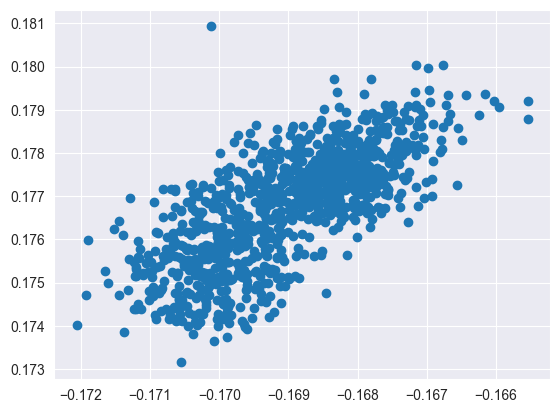

In [24]:
plt.scatter(x_voltage, y_voltage)

### Генерация интервалов

Этот блок:
1. Ограничивает количество точек до 10 000 для упрощения расчётов.
2. Преобразует значения в интервалы с радиусом $ 2^{-14} $.

- **`scalar_to_interval_vec`**: векторизованная функция для создания интервалов.
- **Результат**: два массива интервалов `x_voltage_int_flatten` и `y_voltage_int_flatten`, которые используются для интервалов анализа.

In [25]:
x_voltage_flatten = x_voltage[:10000]
y_voltage_flatten = y_voltage[:10000]

In [26]:
rad = 2 ** -14
x_voltage_int_flatten = scalar_to_interval_vec(x_voltage_flatten, rad)
y_voltage_int_flatten = scalar_to_interval_vec(y_voltage_flatten, rad)

### Тернарный поиск: `ternary_search`

**Назначение:** алгоритм поиска минимума функции на заданном отрезке.

**Принцип работы:** деление отрезка на три части и выбор подотрезка, содержащего минимум.

**Применение:** используется для нахождения оптимальных значений параметров (смещения `a` и масштаба `t`).


In [27]:
def ternary_search(f, left, right, eps):
  while right - left > eps:
    m1 = left + (right - left) / 3
    m2 = right - (right - left) / 3

    if f(m1) < f(m2):
      left = m1
    else:
      right = m2

  return (left + right) / 2

### Функции оценки смещения и масштаба

1. **Функции смещения (`estimate_a`, `estimate_a_mode`, `estimate_a_med_p`, `estimate_a_med_k`)**  
   Оценивают, как сдвиг данных влияет на их схожесть.  

2. **Функции масштаба (`estimate_t`, `estimate_t_mode`, `estimate_t_med_p`, `estimate_t_med_k`)**  
   Определяют, как изменение масштаба данных влияет на их схожесть.

**Метод:** используется индекс Жаккара для измерения степени пересечения интервалов.


In [28]:
def estimate_a(a):
  return np.mean(jaccard_index(x_voltage_int_flatten + a, y_voltage_int_flatten))

def estimate_t(t):
  return np.mean(jaccard_index(x_voltage_int_flatten * t, y_voltage_int_flatten))

def estimate_a_mode(a):
  return np.mean(jaccard_index(mode(x_voltage_int_flatten + a), mode(y_voltage_int_flatten)))

def estimate_t_mode(t):
  x = mode(x_voltage_int_flatten * t)
  x_idx = len(x) // 2
  x = x[x_idx]

  y = mode(y_voltage_int_flatten)
  y_idx = len(y) // 2
  y = y[y_idx]

  return np.mean(jaccard_index(x, y))

def estimate_a_med_p(a):
  return np.mean(jaccard_index(med_p(x_voltage_int_flatten + a), med_p(y_voltage_int_flatten)))

def estimate_t_med_p(t):
  return np.mean(jaccard_index(med_p(x_voltage_int_flatten * t), med_p(y_voltage_int_flatten)))

def estimate_a_med_k(a):
  return np.mean(jaccard_index(med_k(x_voltage_int_flatten + a), med_k(y_voltage_int_flatten)))

def estimate_t_med_k(t):
  return np.mean(jaccard_index(med_k(x_voltage_int_flatten * t), med_k(y_voltage_int_flatten)))

In [29]:
a_1 = ternary_search(estimate_a, 0, 1, 1e-3)
a_1, estimate_a(a_1)

(0.34567254392165103, mpf('-0.520082682359994736789354084260879822119'))

In [30]:
t_1 = ternary_search(estimate_t, -4, 0, 1e-3)
t_1, estimate_t(t_1)

(-1.0531550415372721, mpf('-0.72450202695654638938524888291778612282'))

In [31]:
a_2 = ternary_search(estimate_a_mode, -4, 4, 1e-3)
a_2, estimate_a_mode(a_2)

(0.34670754859447006, mpf('-0.931417373166976599656076102381685052696'))

In [32]:
t_2 = ternary_search(estimate_t_mode, -4, 0, 1e-3)
t_2, estimate_t_mode(t_2)

(-1.0490663581849993, mpf('-0.992910084250674959920779776609843614229'))

In [33]:
a_3 = ternary_search(estimate_a_med_p, -4, 4, 1e-3)
a_3, estimate_a_med_p(a_3)

(0.3461060912748266, mpf('0.116632409627218601963991493888203662446'))

In [34]:
t_3 = ternary_search(estimate_t_med_p, -4, 0, 1e-3)
t_3, estimate_t_med_p(t_3)

(-1.0465045525289232, mpf('0.725781576228221781251791042244809319275'))

In [35]:
a_4 = ternary_search(estimate_a_med_k, -4, 4, 1e-3)
a_4, estimate_a_med_k(a_4)

(0.3461060912748266, mpf('0.11663240962727230615126438912133704171'))

In [36]:
t_4 = ternary_search(estimate_t_med_k, -4, 0, 1e-3)
t_4, estimate_t_med_k(t_4)

(-1.0465045525289232, mpf('0.725781576228148437630775566390009433619'))

### Итог

Код выполняет следующие задачи:
1. Считывание и нормализация данных из бинарных файлов.
2. Представление данных в интервальном виде.
3. Вычисление ключевых характеристик:
   - Мода,
   - Медианы (по двум методам),
   - Индекс Жаккара.
4. Визуализация данных для анализа их распределения.
5. Оценка оптимальных параметров смещения и масштаба данных с использованием тернарного поиска.

**Область применения:** интервальный анализ данных для выявления их характеристик и схожести.
